<a href="https://colab.research.google.com/github/Helena26-ai/Rainforcement_project/blob/Helena/Pong_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium[atari,accept-rom-license]==0.29.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446710 sha256=5404f9fda4289ec66c251f0722836d231013ad87a12528499295f8fff393fed0
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.0
    Uninstalling ale-py-0.11.0:
      Su

In [ ]:
from gymnasium.envs import registry
print([env for env in registry.keys() if "Pong" in env])

['Pong-v0', 'PongDeterministic-v0', 'PongNoFrameskip-v0', 'Pong-v4', 'PongDeterministic-v4', 'PongNoFrameskip-v4', 'Pong-ram-v0', 'Pong-ramDeterministic-v0', 'Pong-ramNoFrameskip-v0', 'Pong-ram-v4', 'Pong-ramDeterministic-v4', 'Pong-ramNoFrameskip-v4', 'ALE/Pong-v5', 'ALE/Pong-ram-v5']


In [ ]:
!pip install stable-baselines3 tensorboard matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00


In [ ]:
import os
#import ale_py
import gymnasium as gym
from gymnasium import spaces
import collections
import typing as tt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import AtariWrapper
from dataclasses import dataclass

ModuleNotFoundError: No module named 'stable_baselines3'

In [ ]:
os.makedirs("my_runs", exist_ok=True)
os.makedirs("my_runs/video", exist_ok=True)

In [ ]:
# DQN
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential( #analiza klatki z gry, wybór cech
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), #filtr o wym. 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        conv_out_size = self.conv(torch.zeros(1, *input_shape)).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions) #zwraca wartości f. Q dla każdej z 6 akcji, wybiera akcję o największej wartości Q
        )

    def forward(self, x): #normalizacja danych i przepuszczenie przez sieć
        return self.fc(self.conv(x.float() / 255))

In [ ]:
class ImageToPyTorch(gym.ObservationWrapper): # zamina kolejności parametrów (wysokość, szerokość, kanał)->(kanał, wysokość, szerokość)
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        self.observation_space = spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=(obs.shape[2], obs.shape[0], obs.shape[1]), dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper): #bufor do przechowywania kilku ostatnich klatek(4), łączy je w jedną obserwację (state)
    def __init__(self, env, n_steps):
        super().__init__(env)
        self.buffer = collections.deque(maxlen=n_steps)
        obs = env.observation_space
        self.observation_space = spaces.Box(
            low=np.repeat(obs.low, n_steps, axis=0),
            high=np.repeat(obs.high, n_steps, axis=0),
            dtype=obs.dtype)

    def reset(self, **kwargs): #inicjalizacja
        for _ in range(self.buffer.maxlen - 1):
            self.buffer.append(self.env.observation_space.low)
        obs, info = self.env.reset(**kwargs)
        return self.observation(obs), info

    def observation(self, observation): #dodawanie ramek
        self.buffer.append(observation)
        return np.concatenate(self.buffer)

def make_env(env_name: str, **kwargs):
    env = gym.make(env_name, **kwargs)
    env = AtariWrapper(env, clip_reward=False, noop_max=0) #upraszcz i normalizuje środowisko, nie wprowadza losowych początkowych ruchów
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=4)
    return env

In [ ]:
DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    done_trunc: bool
    new_state: np.ndarray

#przechowuje wiele doświadczeń: miesza je w czasie, dzięki temu każde batch treningowe jest różnorodne i mniej skorelowane
#experience replay
class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> list: #losuje 32 doświdczenia (state, action, reward, done, next_state)
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon=0.0):
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.tensor(np.array([self.state]), device=device)
            q_vals = net(state_v)
            action = torch.argmax(q_vals).item()

        new_state, reward, done, trunc, _ = self.env.step(action)
        self.total_reward += reward
        self.exp_buffer.append(Experience(self.state, action, reward, done or trunc, new_state))
        self.state = new_state

        if done or trunc:
            r = self.total_reward
            self._reset()
            return r
        return None

def batch_to_tensors(batch, device):
    states = torch.tensor(np.array([e.state for e in batch]), device=device)
    actions = torch.tensor([e.action for e in batch], dtype=torch.long, device=device)
    rewards = torch.tensor([e.reward for e in batch], dtype=torch.float32, device=device)
    dones = torch.tensor([e.done_trunc for e in batch], dtype=torch.bool, device=device)
    next_states = torch.tensor(np.array([e.new_state for e in batch]), device=device)
    return states, actions, rewards, dones, next_states

def calc_loss(batch, net, tgt_net, device):
    states, actions, rewards, dones, next_states = batch_to_tensors(batch, device)
    state_action_values = net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states).max(1)[0]
        next_state_values[dones] = 0.0
    expected_values = rewards + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_values)

# Start training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = make_env(DEFAULT_ENV_NAME)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device) #jest aktualizowana rzadziej, jest kopią net, oblicza wartość docelową, zachowuje stabilność
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
writer = SummaryWriter(log_dir="my_runs")

epsilon = EPSILON_START
frame_idx = 0
best_mean_reward = None
rewards = []
ts = time.time()
ts_frame = 0

while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(rewards[-100:])
        print(f"{frame_idx}: games {len(rewards)}, reward {m_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} f/s")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_mean_reward is None or best_mean_reward < m_reward:
            torch.save(net.state_dict(), f"my_runs/best_{m_reward:.0f}.dat")
            best_mean_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved!")
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    batch = buffer.sample(BATCH_SIZE)
    optimizer.zero_grad()
    loss = calc_loss(batch, net, tgt_net, device)
    loss.backward()
    optimizer.step()

writer.close()

822: games 1, reward -21.000, eps 0.99, speed 602.73 f/s
1892: games 2, reward -20.000, eps 0.99, speed 877.46 f/s
2761: games 3, reward -20.000, eps 0.98, speed 876.55 f/s
3523: games 4, reward -20.250, eps 0.98, speed 876.18 f/s
4639: games 5, reward -20.000, eps 0.97, speed 900.27 f/s
5568: games 6, reward -20.000, eps 0.96, speed 873.61 f/s
6470: games 7, reward -20.143, eps 0.96, speed 881.71 f/s
7232: games 8, reward -20.250, eps 0.95, speed 875.25 f/s
7994: games 9, reward -20.333, eps 0.95, speed 879.72 f/s
8862: games 10, reward -20.300, eps 0.94, speed 856.89 f/s
9652: games 11, reward -20.364, eps 0.94, speed 864.08 f/s
10488: games 12, reward -20.333, eps 0.93, speed 220.41 f/s
11408: games 13, reward -20.308, eps 0.92, speed 173.08 f/s
12248: games 14, reward -20.357, eps 0.92, speed 172.59 f/s
13118: games 15, reward -20.400, eps 0.91, speed 175.75 f/s
13998: games 16, reward -20.438, eps 0.91, speed 175.51 f/s
14958: games 17, reward -20.412, eps 0.90, speed 174.10 f/s
1

In [ ]:
from gymnasium.wrappers import RecordVideo
import glob
from IPython.display import Video, display

ENV_NAME = "PongNoFrameskip-v4"
VIDEO_PATH = "my_runs/video"
MODEL_PATH = sorted(glob.glob("my_runs/*.dat"))[-1]  # ostatni najlepszy model

env = make_env(ENV_NAME, render_mode="rgb_array")
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda x: True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))

state, _ = env.reset()
total_reward = 0.0

while True:
    state_v = torch.tensor(np.expand_dims(state, 0)).to(device)
    q_vals = net(state_v)
    action = torch.argmax(q_vals).item()
    state, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    if done or trunc:
        break

env.close()
print(f"Total reward: {total_reward}")

video_file = glob.glob(f"{VIDEO_PATH}/*.mp4")[0]
display(Video(video_file, embed=True))

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/my_runs/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/my_runs/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/my_runs/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/my_runs/video/rl-video-episode-0.mp4
Total reward: 18.0


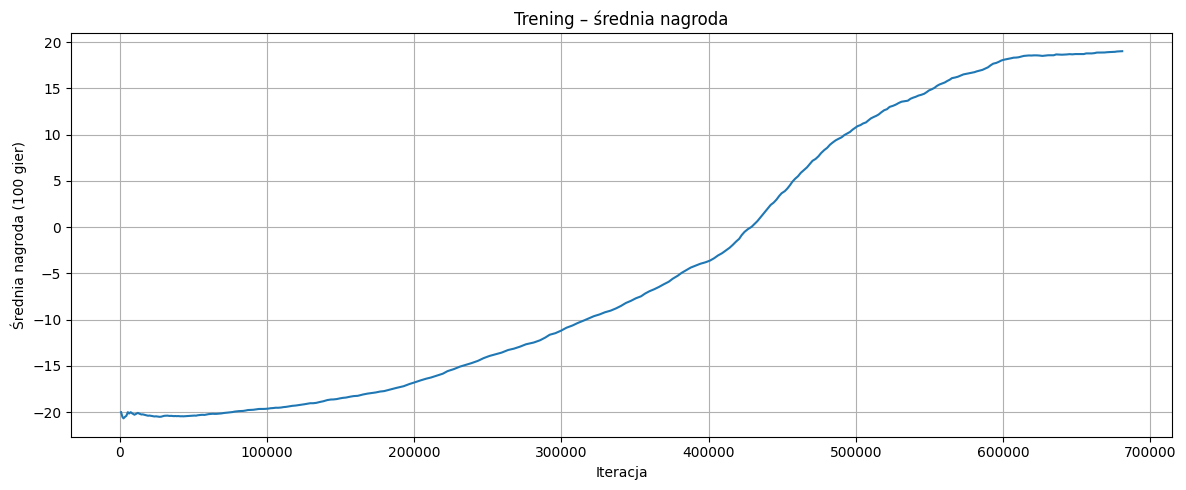

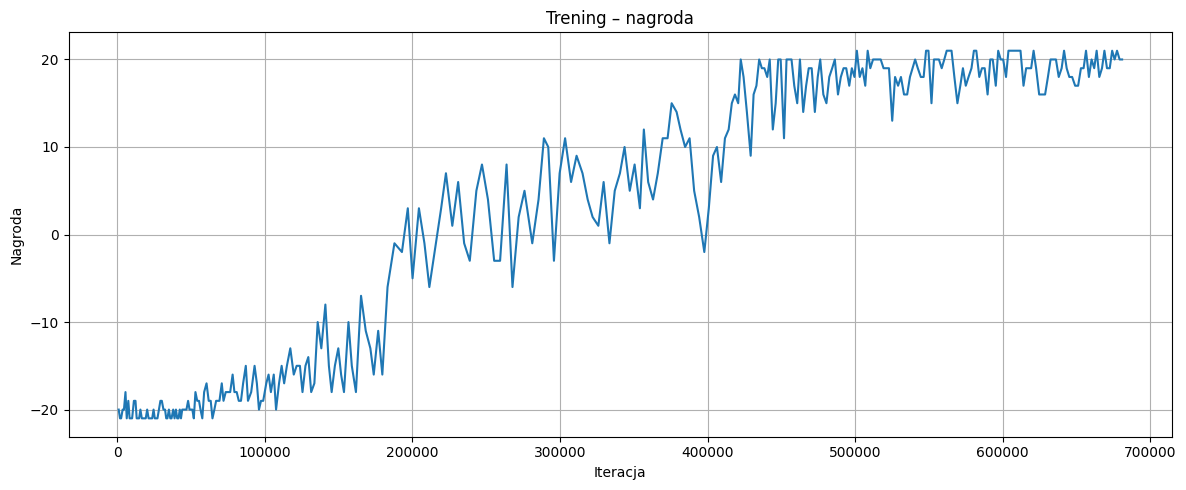

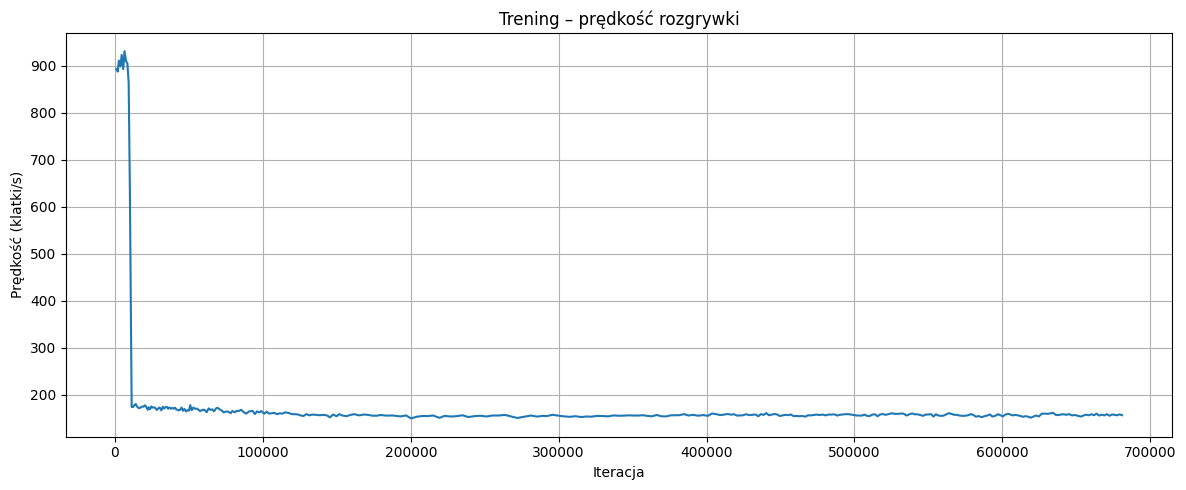

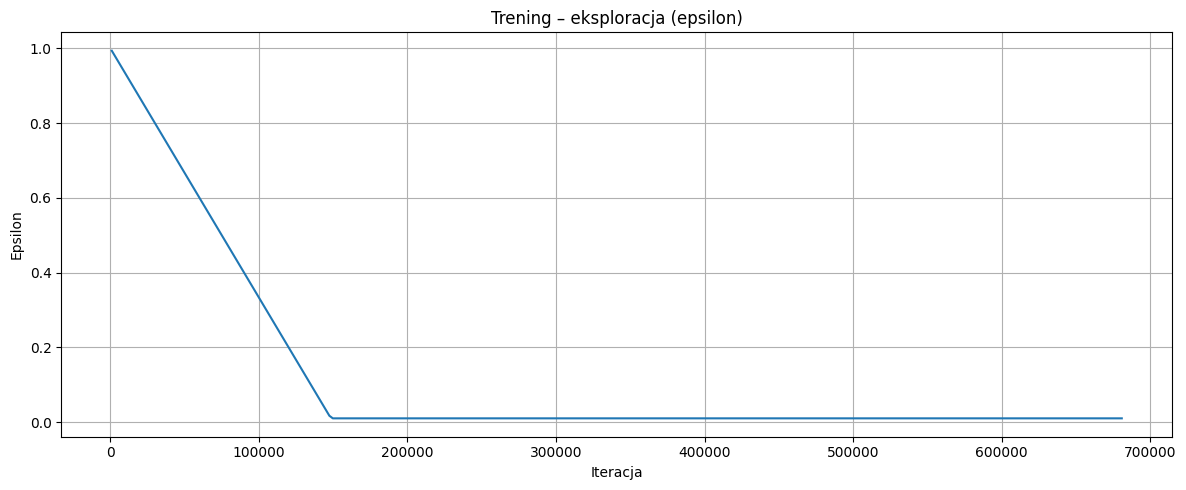

In [ ]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# === Wykres nagród z TensorBoard (trening) ===
event_files = []
for root, dirs, files in os.walk("my_runs"):
    for file in files:
        if file.startswith("events.out.tfevents"):
            event_files.append(os.path.join(root, file))

assert len(event_files) > 0, "Brak logów treningu (TensorBoard)."

ea = event_accumulator.EventAccumulator(event_files[0])
ea.Reload()

# Średnia nagroda (100 ostatnich gier)
rewards = ea.Scalars("reward_100")
steps = [s.step for s in rewards]
reward_values = [s.value for s in rewards]

plt.figure(figsize=(12, 5))
plt.plot(steps, reward_values)
plt.xlabel("Iteracja")
plt.ylabel("Średnia nagroda (100 gier)")
plt.title("Trening – średnia nagroda")
plt.grid()
plt.tight_layout()
plt.savefig("my_runs/dqn_rewards_100.png")
plt.show()

# Nagroda pojedynczej gry
rewards = ea.Scalars("reward")
steps = [s.step for s in rewards]
reward_values = [s.value for s in rewards]

plt.figure(figsize=(12, 5))
plt.plot(steps, reward_values)
plt.xlabel("Iteracja")
plt.ylabel("Nagroda")
plt.title("Trening – nagroda")
plt.grid()
plt.tight_layout()
plt.savefig("my_runs/dqn_rewards.png")
plt.show()

# Prędkość rozgrywki (klatki/s)
speed_scalars = ea.Scalars("speed")
speed_steps = [s.step for s in speed_scalars]
speed_values = [s.value for s in speed_scalars]

plt.figure(figsize=(12, 5))
plt.plot(speed_steps, speed_values)
plt.xlabel("Iteracja")
plt.ylabel("Prędkość (klatki/s)")
plt.title("Trening – prędkość rozgrywki")
plt.grid()
plt.tight_layout()
plt.savefig("my_runs/dqn_speed.png")
plt.show()

# Wartość epsilon
epsilon_scalars = ea.Scalars("epsilon")
epsilon_steps = [s.step for s in epsilon_scalars]
epsilon_values = [s.value for s in epsilon_scalars]

plt.figure(figsize=(12, 5))
plt.plot(epsilon_steps, epsilon_values)
plt.xlabel("Iteracja")
plt.ylabel("Epsilon")
plt.title("Trening – eksploracja (epsilon)")
plt.grid()
plt.tight_layout()
plt.savefig("my_runs/dqn_epsilon.png")
plt.show()